<a href="https://colab.research.google.com/github/rvraghvender/DeepLearningProjects/blob/main/NaturalLanguageProcessing/WordVector/Emojify/Emojify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emojify!

In this project, we're going to use word vector representations to build an Emojifer. 😘❤️😉

We always wanted to make our text messages more expressive. We make emojify project that does automatically.

It takes our input message as:  
```"Congratulations on the promotions! Let's get coffee and talk. Love you!"```    

The emojifier project can automatically turn this into:       
```"Congratulations on the promotions!👍  Let's get coffee and talk. ☕ Love you!❤️"```

More precisely! We'll build a model which inputs a sentence (such as "Let's go see the basetball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾).


## Table of Contents

- [Packages](#0)
- [1 - Baseline Model: Emojifier-V1](#1)
    - [1.1 - Dataset EMOJISET](#1-1)
    - [1.2 - Overview of the Emojifier-V1](#1-2)
    - [1.3 - Implementing Emojifier-V1](#1-3)
        - [Exercise 1 - sentence_to_avg](#ex-1)
    - [1.4 - Implement the Model](#1-4)
        - [Exercise 2 - model](#ex-2)
    - [1.5 - Examining Test Set Performance](#1-5)
- [2 - Emojifier-V2: Using LSTMs in Keras](#2)
    - [2.1 - Model Overview](#2-1)
    - [2.2 Keras and Mini-batching](#2-2)
    - [2.3 - The Embedding Layer](#2-3)
        - [Exercise 3 - sentences_to_indices](#ex-3)
        - [Exercise 4 - pretrained_embedding_layer](#ex-4)
    - [2.4 - Building the Emojifier-V2](#2-4)
        - [Exercise 5 - Emojify_V2](#ex-5)
    - [2.5 - Train the Model](#2-5)
- [3 - Acknowledgments](#3)

## 1 - Packages

In [3]:
%pip install --upgrade emoji==1.6.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170282 sha256=4e9fbbbc00d432d63962970bbbeed54de1c75a83aa832e1cb5a1282d4e0dd330
  Stored in directory: /root/.cache/pip/wheels/83/42/4a/2e5a7b28b80e3a4f143cb5bbfcfbfe54958ccb533bb8ce2a99
Successfully built emoji


In [56]:
import numpy as np
import emoji
import matplotlib.pyplot as plt

import csv
import pandas as pd
from sklearn.metrics import confusion_matrix

from termcolor import colored

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform

%matplotlib inline

## 2 - Baseline Model: Emojifier - V1

### 2.1 - Dataset EMOJISET

Let's start by building a simple baseline classifier.

We have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/NaturalLanguageProcessing/WordVector/Emojify/images/data_set.png?raw=true" style="width:700px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here. </center></caption>

In [5]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [6]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [7]:
def read_csv(filename = 'data/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [8]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [9]:
emoji_dictionary = {#"0": ":red_heart:",    # :heart: prints a black instead of red heart depending on the font
                    "0": "\u2764\ufe0f",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)

In [10]:
def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))

In [11]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):

    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)

    df_conf_norm = df_confusion / df_confusion.sum(axis=1)

    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [12]:

def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.

    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)

    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    any_word = list(word_to_vec_map.keys())[0]
    # number of classes
    n_h = word_to_vec_map[any_word].shape[0]

    for j in range(m):                       # Loop over training examples

        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()

        # Average words' vectors
        avg = np.zeros((n_h,))
        count = 0
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
                count += 1

        if count > 0:
            avg = avg / count

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)

    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))

    return pred

In [44]:
# Compare the two inputs
def comparator(learner, instructor):
    for a, b in zip(learner, instructor):
        if tuple(a) != tuple(b):
            print(colored("Test failed", attrs=['bold']),
                  "\n Expected value \n\n", colored(f"{b}", "green"),
                  "\n\n does not match the input value: \n\n",
                  colored(f"{a}", "red"))
            raise AssertionError("Error in test")
    print(colored("All tests passed!", "green"))

# extracts the description of a given model
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        if (type(layer) == LSTM):
            descriptors.append(layer.input_shape)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.return_sequences)
        if (type(layer) == RepeatVector):
            descriptors.append(layer.n)
        result.append(descriptors)
    return result

Reading csv files for training and testing data

In [15]:
X_train, Y_train = read_csv('train_emoji.csv')
X_test, Y_test = read_csv('tesss.csv')

In [16]:
maxLen = len(max(X_train, key=len).split())

In the following code, we print sentences from X_train and corresponding labels from Y_train.

In [54]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


### 2.2 Overview of the Emojifier - V1

In this section, we'll implement a baseline mode called "Emojifier - V1".

<center>
<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/NaturalLanguageProcessing/WordVector/Emojify/images/image_1.png?raw=true" style="width:900px;height:300px;">
    <caption><center><font color='purple'><b>Figure 2</b>: Baseline model (Emojifier-V1).</center></caption>
</center></font>

#### Inputs and Outputs

* The input of the model is a string corresponding to a sentence (e.g. "I love you")
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from).
* The (1,5) pobability vector is passed to an argmax layer, which extracts the index os the emoji with the highest probability.

#### One-hot Encoding

* To get our labels into a format suitable for training a softmax suitable for traning a softmax classifier, convert $Y$ from its current shape $(m, 1)$ into a "one-hot representation" $(m,5)$.
    * Each row is a one-hot vector giving the label of one example.
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`.

In [18]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [19]:
idx = 50
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


Everything is okay! Now let's move to implement the model.

### 2.3 Implementing the Emojifier - V1

As shown in the figure 2 (above), the first step is to:

* Convert each word in the input sentence into their word vector representations.
* Take an average of the word vectors.

We'll use pre-trained 50-dimensional GloVe embeddings.

In [20]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

We have loaded:

* `word_to_index`: dictionary mapping from words to thier indices in the vocabulary
    * (400,001 words, with valid indices ranging from 0 to 400,000)
* `index_to_word`: dictionary mapping from indices to their correponding words in the vocabulary
* `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

In [21]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


#### TODO 1 - `sentence_to_avg`

Implementing `sentence_to_avg()`

We'll need to carry out two steps:
1. Convert  every sentence to lower-case, then split the sentence into a list of words.
    * `X.lower()` and `X.split()` will be used.
2. For each word in the sentence, access its GloVe representation.

In [55]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the
    GloVe representation of each word and averages its value into a single
    vector encoding the meaning of the sentence.

    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its
                       50-dimensional vector representation

    Returns:
    avg -- average vector encoding information about the sentence, numpy-array
           of shape (J,), where J can be any number
    """
    # Get a valid word contained in the word_to_vec_map.
    any_word = list(word_to_vec_map.keys())[0]

    # Step 1: Split sentence into list of lower case words
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your
    # word vectors.
    avg = np.zeros(word_to_vec_map[any_word].shape)

    # Initialize count to 0
    count = 0

    # Step 2: average the word vectors. You can loop over the words in the list
    # "words".
    for w in words:
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            # Increment count
            count +=1

    if count > 0:
        # Get the average. But only if count > 0
        avg = avg/count

    return avg

#### <font color='red'> Test `sentence_to_avg`  function </font> ####



In [23]:
# BEGIN UNIT TEST
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

def sentence_to_avg_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    avg = target("a a_nw c_w a_s", word_to_vec_map)
    assert tuple(avg.shape) == tuple(word_to_vec_map['a'].shape),  "Check the shape of your avg array"
    assert np.allclose(avg, [1.25, 2.5]),  "Check that you are finding the 4 words"
    avg = target("love a a_nw c_w a_s", word_to_vec_map)
    assert np.allclose(avg, [1.25, 2.5]), "Divide by count, not len(words)"
    avg = target("love", word_to_vec_map)
    assert np.allclose(avg, [0, 0]), "Average of no words must give an array of zeros"
    avg = target("c_se foo a a_nw c_w a_s deeplearning c_nw", word_to_vec_map)
    assert np.allclose(avg, [0.1666667, 2.0]), "Debug the last example"

    print("\033[92mAll tests passed!")

sentence_to_avg_test(sentence_to_avg)

# END UNIT TEST

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
All tests passed!


### 2.4 - Implement the Model

We now have all the pieces to finish implementing the `model()` function. After using `sentence_to_avg()` we need to:

- Pass the average through forward propagation
- Compute the cost
- Backpropagate to update the softmax parameters

#### TODO 2 - model

Implement the `model()` function described in figure (2).
- The equations we need to implement in the forward pass and to compute the cross-entropy cost are below:
- The variable  $Y_{oh}$ ("Y one hot") is the one-hot enconding of the outputs labels.


$$ z^{(i)} = W . avg^{(i)} + b \tag{1}$$

$$ a^{(i)} = softmax(z^{(i)}) \tag{2}$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k) \tag{3}$$


In [24]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.

    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations

    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """

    # Get a valid word contained in the word_to_vec_map
    any_word = list(word_to_vec_map.keys())[0]

    # Initialize cost. It is needed during grading
    cost = 0

    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors

    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))

    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y)

    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples

            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.add(np.dot(W,avg),b)
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(np.dot(Y_oh[i], np.log(a)))

            # Compute gradients
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db

        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

#### <font color='red'> Test `model`  function </font> ####

In [25]:
|# UNIT TEST
def model_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    # Training set. Sentences composed of a_* words will be of class 0 and sentences composed of c_* words will be of class 1
    X = np.asarray(['a a_s synonym_of_a a_n c_sw', 'a a_s a_n c_sw', 'a_s  a a_n', 'synonym_of_a a a_s a_n c_sw', " a_s a_n",
                    " a a_s a_n c ", " a_n  a c c c_e",
                   'c c_nw c_n c c_ne', 'c_e c c_se c_s', 'c_nw c a_s c_e c_e', 'c_e a_nw c_sw', 'c_sw c c_ne c_ne'])

    Y = np.asarray([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

    np.random.seed(10)
    pred, W, b = model(X, Y, word_to_vec_map, 0.0025, 110)

    assert W.shape == (2, 2), "W must be of shape 2 x 2"
    assert np.allclose(pred.transpose(), Y), "Model must give a perfect accuracy"
    assert np.allclose(b[0], -1 * b[1]), "b should be symmetric in this example"

    print("\033[92mAll tests passed!")

model_test(model)

Epoch: 0 --- cost = 0.05105772513207823
Accuracy: 0.9166666666666666
Epoch: 100 --- cost = 0.00970311068897676
Accuracy: 1.0
All tests passed!


In [26]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.9520498812810076
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014807
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]

Great! Our model has pretty high accuracy on the training set. Now we check how it does on the test set:

### 2.5 - Examining Test Set performance

In [27]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


**Note:**

- Random guessing would have had 20% accuracy, given that there are 5 classes. (1/5 = 20%).
- This is pretty good performance after training on only 127 examples.

#### The Model matches Emojis to Relevant words

In the training set, the algorithm saw the sentence
```I love you.```
with the label ❤️.

- We can check that the word "cherish" does not appear in the training set.
- Nonetheless, let's see what happens if we write "I cherish you".

In [28]:
X_my_sentences = np.array(["i cherish you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i cherish you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


#### Amazing!

- Because we adore has a similar embedding as __love__, the algorithm has generalized correctly even to a word it has never has been before.
- Words such as __hear__, __dear__, __beloved__, or __adore__ have embedding vectors similar to __love__.


#### Word Ordering isn't considered in this model

- Note that the model doesn't get the following sentence correct:  
    - ```"not feeling happy"```
- This algorithm ignores word ordering, so is not good at understanding phrases like "not happy".

#### Confusion matrix
- Printing the confusion matrix can also help us understand which classes are more difficult for our model.
- A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

Print the confusion matrix:



(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


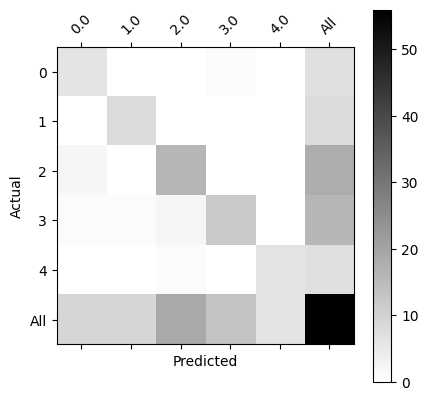

In [29]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

<font color='blue'><b>Points to remember:</b>
- Even with a mere 127 training examples, we can get a reasonably good model for Emojifying.
    - This is due to the generalization power word vectors gives you.
- Emojify - V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"*
    - It doesn't understand combinations of words.
    - It just averages all the words' embedding vectors together, without considering the ordering of words.
</font>
    
**Not to worry! We'll build a better algorithm in the next section!**

## 2 - Emojifier - V2: Using LSTMs in Keras

We're going to build an LSTM model that takes word **sequences** as input! This model will be send to account for word ordering.

Emojfier - V2 will continue to use pre-trained word embeddings to represent words. We'll feed word embeddings into a LSTMs, and the LSTM will learn to predict the most appropriate emoji.

### 2.1 - Model Overview

Here is the Emojifier - V2, we'll implement:

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/NaturalLanguageProcessing/WordVector/Emojify/images/emojifier-v2.png?raw=true" style="width:700px;height:400px;"> <br>
<caption><center><font color='purple'><b>Figure 3</b>: Emojifier-V2. A 2-layer LSTM sequence classifier. </center></caption>

### 2.3 - Keras and Mini-batching

In this part, we want to train Keras using mini-batches. However, most deep learning framewords require that all sequences in the same mini-batch have the **same length.**  

This is what allows vectorization to work: If we had a 3-word sentences and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both as the same time.

**Padding handles the sequence of varying lenghts**
- The common solution to handing sequences of **different length** is to use padding. Specifically:
    - Set a maximum sequence length
    - Pad all sequence to have the same length


**Examples of Padding:**
- Given a maximum sequence length of 20, we could  pad every sentence with "0"'s so that each input sentence is of length 20.
- Thus, the sentence "I love you" would be represented as ($e_I$, e$_{love}$, e$_{you}$, $\vec{0}$, $\vec{0}$,...,$\vec{0}$).
- In this example, any sentence longer than 20 words would have to be truncated.
- One way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set.

### 2.4 - The Embedding layer

In Keras, the embedding matrix is represented as a "layer".

- The embedding matrix maps wods indices to embedding vectors.
    - The word indices are positive integers.
    - The embedding vectors are dense vectors of fixed size.
    - A "dense" vector is the opposite of a sparese vector. It means that most of tis values are non-zeros. As a counter example, a one-hot encoded vector is not "dense".
- The embedding matrix can be derived in two ways:
     - Training a model to derive the embeddings from scratch.
     - Using a pretrained embeddings.

**Using and Updating Pre-trained Embeddings**
In this section, we'll create and `Embedding()` layer in keras
- We'll initialize the Embedding layer with GloVe 50-dimensional vectors.
- In the code below, we'll observe how Keras allows us to either train or leave this layer fixed.
    - Because our traning set is small, we'll leave the GloVe embeddings fixed instead of updaing item.

** Inputs and Outputs to the Embedding Layer**
- The `Embedding()` layer's input is an integer matrix of size (**batch size, max input length**).
    - This input corresponds to sentences converted into lists of indices (integers).
    - The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
- The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

- The figure shows the propagation of two example sentences throught the embedding layer.
    - Both examples have been zero-padded to a length of `max_length=5`.
    - The word embedding are 50 units in length.
    - The final dimension of the representation is `(2, max_len, 50)`

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/NaturalLanguageProcessing/WordVector/Emojify/images/embedding1.png?raw=true" style="width:700px;height:250px;">
<caption><center><font color='purple'><b>Figure 4</b>: Embedding layer</center></caption>

**Prepare the Input Sentences**

**TODO 3 - sentences_to_indices**

Implement the `sentences_to_indices`

The function process an array of sentence $X$ and returns inputs to the embedding layer:
- Convert each training setences into a list of indices (the indices correspond to each word in the sentence)
- Zero-Pad all these lists so that their length is the length of the longest sentence.

In [31]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [57]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4).

    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]  # number of training examples

    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros([m,max_len])

    for i in range(m):  # loop over training examples

        # Convert the ith training sentence in lower case and split is into words.
        # We should get a list of words.
        sentence_words = X[i].lower().split()

        # Initialize j to 0
        j = 0

        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j+1

    return X_indices

#### <font color='red'> Test `sentences_to_indices`  function </font> ####

In [33]:
def sentences_to_indices_test(target):

    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(["i", "like", "learning", "deep", "machine", "love", "smile", '´0.=']):
        word_to_index[val] = idx + 1;

    max_len = 4
    sentences = np.array(["I like deep learning", "deep ´0.= love machine", "machine learning smile"]);
    indexes = target(sentences, word_to_index, max_len)
    print(indexes)

    assert type(indexes) == np.ndarray, "Wrong type. Use np arrays in the function"
    assert indexes.shape == (sentences.shape[0], max_len), "Wrong shape of ouput matrix"
    assert np.allclose(indexes, [[1, 2, 4, 3],
                                 [4, 8, 6, 5],
                                 [5, 3, 7, 0]]), "Wrong values. Debug with the given examples"

    print("\033[92mAll tests passed!")

sentences_to_indices_test(sentences_to_indices)

[[1. 2. 4. 3.]
 [4. 8. 6. 5.]
 [5. 3. 7. 0.]]
All tests passed!


In [34]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


**Building Embedding Layer**

Now, we'll build the `Embedding()` layer in Keras, using pre-trained word vectors.
- The embedding layer toakes as input a list of word indices.
    - `sentences_to_indices()` creats these words indices.
    - The embedding layer will return the word embeddings for a sentences.
    

**TODO 4: pretrained_embedding_layer**

Implement the `pretrained_embedding_layer()` with these steps:
- Initialize the embedding matrix as a numpy array of zeros.
    - The embedding matrix has a row for each unique word in the vocabulary.
        - There is one additional row to handle "unknown" words.
        - So vocab_size is the number of unique words plus one.
    - Each row will store the vector representation of one word.
        - For example, one row may be 50 positions long if using GloVe word vectors.
    - In the code below, `emb_dim` represents the length of a word embedding.
- Fill in each row of the embedding matrix with the vector representation of a word
    - Each word in `word_to_index` is a string.
    - `word_to_vec_map` is a dictionary where the keys are strings and the values are the word vectors.
- Define the Keras embedding layer.
    - Use `Embedding()`
    - The input dimension is equal to the vacubulary length (number of unique words plus one)
    - Make this layer's embedding fixed.
        - If we were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings.
        - In this case, we don't want the model to modify the word embeddings.
- Set the embeddings weights to be equal to the embedding matrix.

In [35]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.

    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """

    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]     # define dimensionality of your GloVe word vectors (= 50)

    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros([vocab_size,emb_dim])

    # Step 2
    # Set each row "idx" of the embedding matrix to be
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_size, emb_dim ,trainable = False)

    # Step 4
    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

#### <font color='red'> Test `pretrained_embedding_layer`  function </font> ####

In [36]:
def pretrained_embedding_layer_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(list(word_to_vec_map.keys())):
        word_to_index[val] = idx;

    np.random.seed(1)
    embedding_layer = target(word_to_vec_map, word_to_index)

    assert type(embedding_layer) == Embedding, "Wrong type"
    assert embedding_layer.input_dim == len(list(word_to_vec_map.keys())) + 1, "Wrong input shape"
    assert embedding_layer.output_dim == len(word_to_vec_map['a']), "Wrong output shape"
    assert np.allclose(embedding_layer.get_weights(),
                       [[[ 3, 3], [ 3, 3], [ 2, 4], [ 3, 2], [ 3, 4],
                       [-2, 1], [-2, 2], [-1, 2], [-1, 1], [-1, 0],
                       [-2, 0], [-3, 0], [-3, 1], [-3, 2], [ 0, 0]]]), "Wrong vaulues"
    print("\033[92mAll tests passed!")


pretrained_embedding_layer_test(pretrained_embedding_layer)

All tests passed!


In [37]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


### 3.4 - Building the Emojifier - V2

Now we're ready to build the Emojifier - V2 model, in which we feed the embedding layer's ouput to a LSTM network!

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/NaturalLanguageProcessing/WordVector/Emojify/images/emojifier-v2.png?raw=true" style="width:700px;height:400px;"> <br>
<caption><center><font color='purple'><b>Figure 3</b>: Emojifier-v2. A 2-layer LSTM sequence classifier. </center></caption></font>


**TODO 5 - Emojify - V2**
Implement `Emojify_V2()`

This function builds a Keras graph of the architecture shown in Figure (3).
- The model takes an input an array of sentences of shape (`m`, `max_len`), defined by `input_shape`.
- The model outputs a softmax probability vector of shape (`m`, `C=5`).
-

In [38]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.

    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """

    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=input_shape,dtype='int32')

    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences, So, set return_sequences = True
    # If return_sequences = False, the LSTM returns only tht last output in output sequence
    X = LSTM(units=128,return_sequences = True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128,return_sequences = False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)

    return model

#### <font color='red'> Test `Emojify_V2`  function </font> ####

In [45]:
def Emojify_V2_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(list(word_to_vec_map.keys())):
        word_to_index[val] = idx;

    maxLen = 4
    model = target((maxLen,), word_to_vec_map, word_to_index)

    expectedModel = [['InputLayer', [(None, 4)], 0], ['Embedding', (None, 4, 2), 30], ['LSTM', (None, 4, 128), 67072, (None, 4, 2), 'tanh', True], ['Dropout', (None, 4, 128), 0, 0.5], ['LSTM', (None, 128), 131584, (None, 4, 128), 'tanh', False], ['Dropout', (None, 128), 0, 0.5], ['Dense', (None, 5), 645, 'linear'], ['Activation', (None, 5), 0]]
    comparator(summary(model), expectedModel)


Emojify_V2_test(Emojify_V2)

All tests passed!


Run the following cell to create our model and check its summary.

* Because all sentences in the dataset are less than 10 words, `max_len = 10` was chosen.  
* We should see that your architecture uses 20,223,927 parameters, of which 20,000,050 (the word embeddings) are non-trainable, with the remaining 223,877 being trainable.
* Because your vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters.

In [46]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 10, 50)            20000050  
                                                                 
 lstm_8 (LSTM)               (None, 10, 128)           91648     
                                                                 
 dropout_8 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 645 

#### Compile the Model

As usual, after creating our model in Keras, we need to compile it and define what loss, optimizer and metrics we want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 3.5 - Train the Model

It's time to train our model! Our Emojifier - V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of shape`). Thus, we have to convert X_train (array of sentences as strings) to X_train_indcies (array of sentences as list of words indices), and Y_train (label as one-hot vectors).

In [48]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Fit the Keras model on `X_train_indices` and `Y_train_oh`, using `epochs = 50` and `batch_size = 32`.

In [49]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 5s 36ms/step - loss: 1.6000 - accuracy: 0.2727
Epoch 2/50
5/5 [==============================] - 0s 33ms/step - loss: 1.5295 - accuracy: 0.2803
Epoch 3/50
5/5 [==============================] - 0s 33ms/step - loss: 1.4539 - accuracy: 0.4318
Epoch 4/50
5/5 [==============================] - 0s 35ms/step - loss: 1.3928 - accuracy: 0.4242
Epoch 5/50
5/5 [==============================] - 0s 31ms/step - loss: 1.2836 - accuracy: 0.4470
Epoch 6/50
5/5 [==============================] - 0s 37ms/step - loss: 1.1884 - accuracy: 0.5227
Epoch 7/50
5/5 [==============================] - 0s 38ms/step - loss: 1.0449 - accuracy: 0.6515
Epoch 8/50
5/5 [==============================] - 0s 36ms/step - loss: 0.9460 - accuracy: 0.7045
Epoch 9/50
5/5 [==============================] - 0s 38ms/step - loss: 0.7624 - accuracy: 0.7121
Epoch 10/50
5/5 [==============================] - 0s 40ms/step - loss: 0.6732 - accuracy: 0.7424
Epoch 11/50
5/5 [============

Our model should perform around **90% to 100% accuracy** on the training set.

In [50]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 1s 19ms/step - loss: 0.4464 - accuracy: 0.8571

Test accuracy =  0.8571428656578064


In [51]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

2/2 [==============================] - 1s 11ms/step
Expected emoji:😄 prediction: he got a very nice raise	❤️
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: go away	⚾


In [52]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.
x_test = np.array(['I cannot play'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

1/1 [==============================] - 0s 28ms/step
I cannot play 😞
